In [20]:
import ijson

file_path = './inputs/merged_news.json'

with open(file_path, 'rb') as f:
    objects = ijson.items(f, 'item') 
    raw_data = [
    (i, obj) for i, obj in enumerate(objects)
]

## Create Index

In [ ]:
import time
from pymilvus import MilvusClient

# ==========================================
# 1. CONFIGURATION
# ==========================================
MILVUS_URI = "http://127.0.0.1:19530"
COLLECTION_NAME = "globaltech_nlp_project"

client = MilvusClient(uri=MILVUS_URI)
print(f"✅ Connected to Milvus at {MILVUS_URI}")

# ==========================================
# 2. FORCE CLEANUP (QUAN TRỌNG)
# ==========================================
print("🔍 Checking existing indexes...")

try:
    # 1. Release RAM trước
    client.release_collection(collection_name=COLLECTION_NAME)
    print("✅ Collection released from RAM.")

    # 2. Liệt kê tất cả Index đang có
    indexes = client.list_indexes(collection_name=COLLECTION_NAME)
    print(f"📋 Found indexes: {indexes}")

    # 3. Duyệt và xóa từng cái một (Bất kể tên là gì)
    for index_name in indexes:
        print(f"🔥 Dropping index: '{index_name}'...")
        client.drop_index(collection_name=COLLECTION_NAME, index_name=index_name)
        time.sleep(1) # Đợi 1 chút cho Milvus kịp xử lý
        
    print("✅ All old indexes dropped successfully.")

except Exception as e:
    # Nếu chưa có index nào thì nó sẽ báo lỗi, ta cứ bỏ qua
    print(f"⚠️ Cleanup info (might be empty): {e}")

# ==========================================
# 3. BUILD INDEX: IVF_SQ8
# ==========================================
# Params cho IVF_SQ8
index_params = MilvusClient.prepare_index_params()
nlist_param = 2048 

index_params.add_index(
    field_name="vector",
    index_type="IVF_SQ8", 
    metric_type="COSINE", 
    params={"nlist": nlist_param},
    index_name="vector_index_optimized" # Đặt tên mới cho chắc
)

print(f"⏳ Building IVF_SQ8 Index (nlist={nlist_param})...")
start_time = time.time()

try:
    client.create_index(
        collection_name=COLLECTION_NAME,
        index_params=index_params
    )
    print(f"✅ Index built successfully in {time.time() - start_time:.2f} seconds.")

    # ==========================================
    # 4. LOAD TO RAM
    # ==========================================
    print("⏳ Loading collection into RAM...")
    client.load_collection(collection_name=COLLECTION_NAME)
    
    # Kiểm tra lại lần cuối
    state = client.get_load_state(collection_name=COLLECTION_NAME)
    print(f"🎉 SYSTEM READY! Load state: {state}")

except Exception as e:
    print(f"❌ Failed to build index: {e}")

## Querying 

In [1]:
import time
import datetime
from pymilvus import MilvusClient
from sentence_transformers import SentenceTransformer

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Use 127.0.0.1 to avoid IPv6 connection issues on Windows Docker
MILVUS_URI = "http://127.0.0.1:19530" 
COLLECTION_NAME = "globaltech_nlp_project"

# ==========================================
# 2. LOAD RESOURCES
# ==========================================
print("Loading embedding model...")
model = SentenceTransformer("hiieu/halong_embedding")
print("Model loaded.")

print("Connecting to Milvus...")
client = MilvusClient(uri=MILVUS_URI)

# Load collection to RAM (Essential for search)
client.load_collection(COLLECTION_NAME)
print(f"Collection '{COLLECTION_NAME}' loaded and ready.")

e:\Anaconda\envs\LLMs-env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Loading embedding model...


e:\Anaconda\envs\LLMs-env\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded.
Connecting to Milvus...
Collection 'globaltech_nlp_project' loaded and ready.


In [ ]:


# ==========================================
# 3. SEARCH FUNCTION
# ==========================================
def search_similar_news(query_text, top_k=5):
    print(f"\nQuery: '{query_text}'")
    t0 = time.time()
    
    # 1. Embed query text
    query_vector = model.encode([query_text])
    
    # 2. Search in Milvus
    # CRITICAL FOR IVF_SQ8: You must specify 'nprobe'
    search_res = client.search(
        collection_name=COLLECTION_NAME,
        data=query_vector,
        limit=top_k,
        # 'nprobe': Number of clusters to search. 
        # Higher = More accurate but slower. 
        # Recommended: 10% of nlist (e.g., if nlist=2048, try nprobe=128 or 64)
        search_params={
            "metric_type": "COSINE", 
            "params": {"nprobe": 64} 
        },
        output_fields=["title", "text", "url", "chunk_index", "description", "author_name", "created_time"],
    )
    t1 = time.time()
    
    print(f"Search time: {(t1-t0)*1000:.2f} ms")
    print("=" * 80)
    
    # 3. Display results
    for hits in search_res:
        for i, hit in enumerate(hits):
            score = hit['distance'] 
            entity = hit['entity']
            
            # Format timestamp to readable date
            created_ts = entity.get('created_time', 0)
            try:
                # Assuming timestamp is in milliseconds
                date_str = datetime.datetime.fromtimestamp(created_ts / 1000).strftime('%Y-%m-%d %H:%M:%S')
            except:
                date_str = "Unknown Date"

            print(f"#{i+1} [Score: {score:.4f}] - {entity.get('title', 'No Title')}")
            print(f"🔗 {entity.get('url', '#')}")
            print(f"📝 Description: {entity.get('description', 'No Description')}")
            print(f"📅 Date: {date_str} | 👤 Author: {entity.get('author_name', 'Unknown')}")
            
            # Preview content
            content_preview = entity.get('text', '')[:250].replace('\n', ' ')
            print(f"📄 Snippet (Chunk {entity.get('chunk_index')}): \"{content_preview}...\"")
            print("-" * 80)

e:\Anaconda\envs\LLMs-env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Loading embedding model...


e:\Anaconda\envs\LLMs-env\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded.
Connecting to Milvus...
Collection 'globaltech_nlp_project' loaded and ready.


In [2]:
search_similar_news("Cục trưởng A05 hiện nay là người nào?")


Query: 'Cục trưởng A05 hiện nay là người nào?'
Search time: 683.03 ms
#1 [Score: 0.7104] - Hưởng ứng Công ước Hà Nội: Khởi động chiến dịch chống lừa đảo trực tuyến
🔗 https://www.vietnamplus.vn/huong-ung-cong-uoc-ha-noi-khoi-dong-chien-dich-chong-lua-dao-truc-tuyen-post1070249.vnp
📝 Description: Trong bối cảnh các hình thức lừa đảo trực tuyến ngày càng tinh vi, Chiến dịch “Chống lừa đảo trực tuyến năm 2025 - Chậm mà chắc'” được triển khai trên quy mô toàn quốc.
📅 Date: 2025-10-14 16:09:17 | 👤 Author: Vietnam Plus
📄 Snippet (Chunk 3): "Đại tá Hà Văn Bắc - Phó Cục trưởng Cục A05 (Bộ Công an). (Ảnh: PV/Vietnam+)..."
--------------------------------------------------------------------------------
#2 [Score: 0.5759] - 
🔗 https://fireant.vn/bai-viet/beee8f28-1f03-4569-98a6-fd4afe1236c9/35424045
📝 Description: 
📅 Date: 2025-09-17 07:45:51 | 👤 Author: MẬT THÁM LICOGI (LIC) 
📄 Snippet (Chunk 0): "Tú Phạm: Sao em vẫn chưa bị A05 xích nhỉ ?..."
----------------------------------------------------

In [3]:
search_similar_news("Danh sách cục trưởng BCA")


Query: 'Danh sách cục trưởng BCA'
Search time: 322.19 ms
#1 [Score: 0.4695] - Lào Cai: Người chăn nuôi thích ứng với dịch tả lợn châu Phi - Tin tức Chăn nuôi - Tạp chí Chăn nuôi Việt Nam
🔗 https://nguoichannuoi.vn/lao-cai-nguoi-chan-nuoi-thich-ung-voi-dich-ta-lon-chau-phi/
📝 Description: Dịch tả lợn châu Phi đang gây thiệt hại lớn cho ngành chăn nuôi ở Lào Cai. Trước những khó khăn này, nhiều hộ dân đã linh hoạt chuyển hướng sang nuôi gia cầm, gia súc và thủy sản, góp phần bù đắp và ổn định nguồn cung thực phẩm cho thị trường.
📅 Date: 2025-09-23 03:12:29 | 👤 Author: Tạp chí Người chăn nuôi
📄 Snippet (Chunk 7): "Bà Cao Thị Hòa Bình – Chi cục trưởng Chi cục Trồng trọt, Bảo vệ thực vật và Chăn nuôi, Thú y, Thủy sản tỉnh...."
--------------------------------------------------------------------------------
#2 [Score: 0.4612] - Thay đổi lớn về tổ chức, thẩm quyền và trang phục Quản lý thị trường từ năm 2025
🔗 https://baocaovien.vn/tin-tuc/thay-doi-lon-ve-to-chuc-tham-quyen-va-trang-phuc-qua

In [4]:
search_similar_news("giới thiệu về 4 nghị quyết đột phá chiến lược")


Query: 'giới thiệu về 4 nghị quyết đột phá chiến lược'
Search time: 251.05 ms
#1 [Score: 0.7297] - Khẩn trương kiện toàn hệ thống tổ chức ngành y tế phù hợp chính quyền 3 cấp
🔗 https://nhandan.vn/khan-truong-kien-toan-he-thong-to-chuc-nganh-y-te-phu-hop-chinh-quyen-3-cap-post914419.html
📝 Description: Sáng 10/10, tại Trụ sở Trung ương Đảng, Thường trực Ban Bí thư Trần Cẩm Tú chủ trì buổi làm việc với Đảng ủy Bộ Y tế và các ban, bộ, ngành Trung ương về tình hình triển khai thực hiện Nghị quyết số 72-NQ/TW ngày 9/9/2025 của Bộ Chính trị về một số giải pháp đột phá, tăng cường bảo vệ, chăm sóc và nâng cao sức khỏe nhân dân.
📅 Date: 2025-10-10 17:47:43 | 👤 Author: NHÂN DÂN
📄 Snippet (Chunk 4): "đảm bám sát 3 đột phá chiến lược (thể chế, nguồn nhân lực, kết cấu hạ tầng) trong tổng thể các Nghị quyết quan trọng mà Bộ Chính trị đã ban hành thời gian qua..."
--------------------------------------------------------------------------------
#2 [Score: 0.6490] - Bối cảnh tình hình thế giới hiện n

In [5]:
search_similar_news("tình hình chiến sự cam - thái lan mới nhất")


Query: 'tình hình chiến sự cam - thái lan mới nhất'
Search time: 223.69 ms
#1 [Score: 0.4205] - 
🔗 https://fireant.vn/bai-viet/ce9ed439-58cd-4c32-81a0-e235e198b00c/30820389
📝 Description: 
📅 Date: 2025-02-26 09:35:18 | 👤 Author: Nguyễn Hữu Quang
📄 Snippet (Chunk 0): "Tình hình này Chắc Về 1.8 hôm nay hoặc mai..."
--------------------------------------------------------------------------------
#2 [Score: 0.4169] - Việt Nam - Lào - Campuchia diễn tập cứu hộ, cứu nạn chung
🔗 https://khoahocdoisong.vn/viet-nam-lao-campuchia-dien-tap-cuu-ho-cuu-nan-chung-post2149061084.html
📝 Description: Cuộc diễn tập chung là dịp để quân đội Việt Nam - Lào - Campuchia chia sẻ những kinh nghiệm thực tế trong công tác cứu hộ, cứu nạn.
📅 Date: 2025-10-15 21:30:48 | 👤 Author: Báo Khoa học và Đời sống
📄 Snippet (Chunk 3): "Phát biểu tại cuộc diễn tập, Trung tướng Saichay Kommasith, Thứ trưởng Bộ Quốc phòng, Tổng Tham mưu trưởng Quân đội nhân dân Lào nhấn mạnh diễn tập cứu hộ, cứu nạn chung giữa Quân đội ba nư

In [6]:
search_similar_news("Hãy giúp tôi vị trí địa lý của xã Đạ Tẻh 3, tỉnh Lâm Đồng")


Query: 'Hãy giúp tôi vị trí địa lý của xã Đạ Tẻh 3, tỉnh Lâm Đồng'
Search time: 198.68 ms
#1 [Score: 0.4334] - Hà Nội sắp xây dựng đường rộng 120m kết nối sân bay Gia Bình
🔗 https://laodong.vn/xa-hoi/ha-noi-sap-xay-dung-duong-rong-120m-ket-noi-san-bay-gia-binh-1578679.ldo
📝 Description: Hà Nội dự kiến từ nay đến năm 2026 sẽ xây dựng tuyến đường kết nối sân bay Gia Bình (Bắc Ninh), sơ bộ tổng mức đầu tư khoảng 32.970...
📅 Date: 2025-09-22 18:13:50 | 👤 Author: LAO ĐỘNG
📄 Snippet (Chunk 7): ".- Khu đất số 3 tại xã Phù Đổng, thành phố Hà Nội có diện tích khoảng 323,3ha thuộc Quy hoạch phân khu đô thị khu vực mở rộng phía Đông...."
--------------------------------------------------------------------------------
#2 [Score: 0.4334] - Trưởng thôn Ðiểu K’Ðốt tận tâm vì dân
🔗 https://baolamdong.vn/truong-thon-ieu-k-ot-tan-tam-vi-dan-393135.html
📝 Description: Một trưởng thôn vùng sâu của Lâm Đồng với uy tín của mình đã vận động người dân chung tay xây dựng nông thôn mới, bài trừ hủ tục, giữ gìn

In [7]:
search_similar_news("Sri Lanka ở đâu?")


Query: 'Sri Lanka ở đâu?'
Search time: 152.40 ms
#1 [Score: 0.5024] - Di sản Phật giáo Nam Tông và kho tàng chú giải Pali tại Sri Lanka
🔗 https://tapchinghiencuuphathoc.vn/di-san-phat-giao-nam-tong-va-kho-tang-chu-giai-pali-tai-sri-lanka.html
📝 Description: Thông điệp trí tuệ và từ bi của đức Phật, được lan truyền từ Sri Lanka, vẫn đang âm thầm nuôi dưỡng hàng triệu con người trên khắp thế giới, gieo trồng hạt giống giác ngộ và an lạc giữa cuộc đời đầy biến động.
📅 Date: 2025-09-04 09:05:00 | 👤 Author: Tạp chí nghiên cứu phật học
📄 Snippet (Chunk 0): "Thường Nguyên (chuyển ngữ và biên tập) Tạp chí Nghiên cứu Phật học - Số tháng 09/2025 Sri Lanka, đảo quốc nằm ở Nam Á, được biết đến như vùng đất bảo tồn truyền thống Phật giáo Theravāda lâu đời nhất. Kể từ khi chính pháp được truyền đến đảo quốc man..."
--------------------------------------------------------------------------------
#2 [Score: 0.4447] - Sách và những giao lưu văn hoá đặc sắc tại Lễ hội văn hoá Thế giới tại Hà Nội lần th

In [8]:
search_similar_news("cục trưởng a01 là ai?")


Query: 'cục trưởng a01 là ai?'
Search time: 203.69 ms
#1 [Score: 0.5097] - Kiên quyết không để xảy ra tình trạng cán bộ vừa quy hoạch, bổ nhiệm lại bị xử lý
🔗 https://voz.vn/t/kien-quyet-khong-%C4%91e-xay-ra-tinh-trang-can-bo-vua-quy-hoach-bo-nhiem-lai-bi-xu-ly.1160891/
📝 Description: UBND TP.HCM đã ban hành Chỉ thị 01 về tăng cường và nâng cao hiệu quả công tác thanh tra, kiểm tra, tiếp công dân, giải quyết khiếu nại, tố cáo, kiến nghị...
📅 Date: 2025-10-21 13:06:28 | 👤 Author: Paranexus
📄 Snippet (Chunk 0): "UBND TP.HCM đã ban hành Chỉ thị 01 về tăng cường và nâng cao hiệu quả công tác thanh tra, kiểm tra, tiếp công dân, giải quyết khiếu nại, tố cáo, kiến nghị, phản ánh và phòng, chống tham nhũng, lãng phí, tiêu cực.. Người đứng đầu phải gương mẫu​. Tron..."
--------------------------------------------------------------------------------
#2 [Score: 0.5085] - Kiên quyết không để xảy ra tình trạng cán bộ vừa quy hoạch, bổ nhiệm lại bị xử lý
🔗 https://plo.vn/kien-quyet-khong-de-xay-ra-

In [9]:
search_similar_news("Sinh 20/12/1976 dương lịch, nữ, đặt bàn làm việc hướng nào")


Query: 'Sinh 20/12/1976 dương lịch, nữ, đặt bàn làm việc hướng nào'
Search time: 170.87 ms
#1 [Score: 0.5213] - Bộ Công an hướng dẫn chi tiết tuổi nghỉ hưu theo từng nhóm sĩ quan
🔗 https://doanhnghiepkinhtexanh.vn/bo-cong-an-huong-dan-chi-tiet-tuoi-nghi-huu-theo-tung-nhom-si-quan-a39736.html
📝 Description: Bộ Công an vừa ban hành Thông tư 88/2025/TT-BCA quy định chi tiết lộ trình tuổi nghỉ hưu thấp nhất của sĩ quan, hạ sĩ quan và chiến sĩ Công an nhân dân. Thông tư này hướng dẫn thực hiện bảo hiểm xã hội bắt buộc, đồng thời làm rõ các trường hợp được nghỉ hưu sớm hơn so với quy định chung.
📅 Date: 2025-10-22 19:20:22 | 👤 Author: Tạp chí Doanh nghiệp và Kinh tế xanh
📄 Snippet (Chunk 13): "4 1975 11 2026 11 1979 12 2026 5 1975 12 2026 12 1979 1 2027 6 1975 1 2027 1 1980 47 tuổi 4 tháng 6 2027 7 1975 51 tuổi 9 tháng 5 2027 2 1980 7 2027 8 1975 6 2027 3 1980 8 2027 9 1975 7 2027 4 1980 9 2027 10 1975 8 2027 5 1980 10 2027 11 1975 9 2027 ..."
-----------------------------------------------

In [10]:
search_similar_news("Công an nhân dân là những ai")


Query: 'Công an nhân dân là những ai'
Search time: 162.31 ms
#1 [Score: 0.6921] - Lực lượng Công an nhân dân chủ động ứng phó với bão số 12 và nguy cơ mưa lớn diện rộng
🔗 https://bocongan.gov.vn/bai-viet/luc-luong-cong-an-nhan-dan-chu-dong-ung-pho-voi-bao-so-12-va-nguy-co-mua-lon-dien-rong-1760964108
📝 Description: Ngày 20/10/2025, Bộ Công an có Công điện số 29/CĐ-BCA-V01 gửi Công an các đơn vị, địa phương về việc chủ động ứng phó với bão số 12 và nguy cơ mưa lớn diện rộng.
📅 Date: 2025-10-20 00:00:00 | 👤 Author: Cổng thông tin điện tử Bộ Công an
📄 Snippet (Chunk 20): "... của lực lượng Công an nhân dân...."
--------------------------------------------------------------------------------
#2 [Score: 0.6921] - Lực lượng Công an nhân dân chủ động ứng phó với bão số 12 và nguy cơ mưa lớn diện rộng
🔗 https://bocongan.gov.vn/bai-viet/luc-luong-cong-an-nhan-dan-chu-dong-ung-pho-voi-bao-so-12-va-nguy-co-mua-lon-dien-rong-1760964108
📝 Description: Ngày 20/10/2025, Bộ Công an có Công điện số 29

In [11]:
search_similar_news("vụ cháy tại xã Hòa Lạc")


Query: 'vụ cháy tại xã Hòa Lạc'
Search time: 137.43 ms
#1 [Score: 0.6553] - Thắp hương xong rời đi, người phụ nữ làm cháy 4 căn nhà
🔗 https://dantri.com.vn/ban-doc/thap-huong-xong-roi-di-nguoi-phu-nu-lam-chay-4-can-nha-20250909090647231.htm
📝 Description: (Dân trí) - Ba căn nhà bị thiêu rụi hoàn toàn, một căn bị cháy xém ở xã Hòa Lạc (tỉnh An Giang) sau khi một người phụ nữ thắp hương rồi rời đi không trông
📅 Date: 2025-09-09 09:49:00 | 👤 Author: Dân Trí
📄 Snippet (Chunk 0): "Ngày 9/9, UBND xã Hòa Lạc (tỉnh An Giang) xác nhận trên địa bàn vừa xảy ra một vụ hỏa hoạn nghiêm trọng gây thiệt hại lớn về tài sản.Theo thông tin ban đầu, vụ cháy bùng phát vào khoảng 18h20 ngày 8/9 tại nhà ông Phạm Quý Tính (45 tuổi, ngụ ấp Hòa Ph..."
--------------------------------------------------------------------------------
#2 [Score: 0.6288] - An Giang: Thắp hương gây cháy 4 căn nhà
🔗 https://home.vn/threads/an-giang-thap-huong-gay-chay-4-can-nha.35731/
📝 Description: Một phút bất cẩn trong sinh hoạt t

In [12]:
search_similar_news("nghị định 144 còn hiệu lực không")


Query: 'nghị định 144 còn hiệu lực không'
Search time: 167.25 ms
#1 [Score: 0.4977] - Điều kiện xét nâng ngạch công chức
🔗 https://baoquangninh.vn/dieu-kien-xet-nang-ngach-cong-chuc-3374427.html
📝 Description: Bà Nguyễn Thị Trang (Nghệ An) là công chức, được tuyển dụng từ tháng 4/2019 theo Nghị định số 140/2017/NĐ-CP. Từ khi được tuyển dụng, bà có 5 năm hoàn thành tốt nhiệm vụ trở lên, trong đó có 2 năm hoàn thành xuất sắc nhiệm vụ.
📅 Date: 2025-09-04 16:57:13 | 👤 Author: Đài Phát thanh và Truyền hình Quảng Ninh
📄 Snippet (Chunk 3): ". Trường hợp chính sách tương ứng quy định tại Nghị định này có lợi hơn so với quy định tại Nghị định số 140/2017/NĐ-CP thì áp dụng theo quy định tại Nghị định này"..."
--------------------------------------------------------------------------------
#2 [Score: 0.4977] - Điều kiện xét nâng ngạch công chức
🔗 https://baochinhphu.vn/dieu-kien-xet-nang-ngach-cong-chuc-102250903155037393.htm
📝 Description: (Chinhphu.vn) - Bà Nguyễn Thị Trang (Nghệ An) là công c

In [14]:
search_similar_news("Thế nào là dân tộc thiểu số? Thế nào là dân tộc chiếm đa số? Thế nào là dân tộc thiểu số rất ít người?")


Query: 'Thế nào là dân tộc thiểu số? Thế nào là dân tộc chiếm đa số? Thế nào là dân tộc thiểu số rất ít người?'
Search time: 140.00 ms
#1 [Score: 0.4222] - Không ngừng đổi mới công tác mặt trận
🔗 https://nhandan.vn/khong-ngung-doi-moi-cong-tac-mat-tran-post920054.html
📝 Description: Mặt trận Tổ quốc Việt Nam tỉnh Đồng Nai hiện nay chú trọng xây dựng, nâng cao chất lượng đội ngũ cán bộ; đồng thời tiếp tục đổi mới mạnh mẽ tổ chức bộ máy, nội dung và phương thức hoạt động.
📅 Date: 2025-11-02 21:53:51 | 👤 Author: NHÂN DÂN
📄 Snippet (Chunk 8): "Đặc thù tỉnh Đồng Nai đa dân tộc, đa tôn giáo với đồng bào các dân tộc thiểu số chiếm tỷ lệ hơn 9% dân số với khoảng 421 nghìn người; đồng bào các tôn giáo chiếm khoảng 60% dân số với hơn 2,6 triệu tín đồ..."
--------------------------------------------------------------------------------
#2 [Score: 0.4200] - Tây Ninh hoàn thành nhiều mục tiêu Chương trình 1719
🔗 http://ubdkcgvn.org.vn/vi/tin-tuc-hoat-dong/tay-ninh-hoan-thanh-nhieu-muc-tieu-chuong-t

---

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
reranker = CrossEncoder('itdainb/PhoRanker', max_length=256, device=device)

def search_with_rerank(query_text, top_k=5, candidate_limit=50):
    print(f"\n🔎 Query: '{query_text}'")
    t0 = time.time()
    
    # 1. Embed query text
    query_vector = model.encode([query_text])
    
    # 2. Search in Milvus (Retrieve Candidates)
    # Lấy nhiều hơn top_k (ví dụ lấy 50) để Reranker có cái mà lọc
    search_res = client.search(
        collection_name=COLLECTION_NAME,
        data=query_vector,
        limit=candidate_limit, 
        search_params={
            "metric_type": "COSINE", 
            "params": {"nprobe": 64} 
        },
        # Quan trọng: Phải lấy đủ các trường để hiển thị sau này
        output_fields=["title", "text", "url", "chunk_index", "description", "author_name", "created_time"],
    )
    
    # 3. Reranking Logic
    milvus_hits = search_res[0]
    
    if not milvus_hits:
        print("❌ No results found in Milvus.")
        return

    # Chuẩn bị dữ liệu cho Cross-Encoder: List các cặp [Query, Document Text]
    cross_inp = [[query_text, hit['entity']['text']] for hit in milvus_hits]
    
    # Chấm điểm lại (Score này chính xác hơn Cosine distance)
    cross_scores = reranker.predict(cross_inp)
    
    # Gán điểm mới vào kết quả
    for idx, hit in enumerate(milvus_hits):
        hit['cross_score'] = cross_scores[idx]
        
    # Sắp xếp giảm dần theo điểm Rerank
    reranked_hits = sorted(milvus_hits, key=lambda x: x['cross_score'], reverse=True)
    
    t1 = time.time()
    print(f"⏱  Total Search & Rerank time: {(t1-t0)*1000:.2f} ms")
    print("=" * 80)
    
    # 4. Display Results (Theo format của bạn)
    # Chỉ lấy top_k kết quả tốt nhất sau khi rerank
    for i, hit in enumerate(reranked_hits[:top_k]):
        entity = hit['entity']
        score = hit['cross_score'] # Điểm của Reranker (thường từ -10 đến 10)
        
        # Format timestamp to readable date
        created_ts = entity.get('created_time', 0)
        try:
            date_str = datetime.datetime.fromtimestamp(created_ts / 1000).strftime('%Y-%m-%d %H:%M:%S')
        except:
            date_str = "Unknown Date"

        # Logic lọc ngưỡng (Optional): Nếu điểm thấp quá (< -4) thì coi như rác
        # Bạn có thể bỏ qua if này nếu muốn luôn hiện đủ 5 kết quả
        if score < -4.0:
            continue

        print(f"#{i+1} [Rerank Score: {score:.4f}] - {entity.get('title', 'No Title')}")
        print(f"🔗 {entity.get('url', '#')}")
        print(f"📝 Description: {entity.get('description', 'No Description')}")
        print(f"📅 Date: {date_str} | 👤 Author: {entity.get('author_name', 'Unknown')}")
        
        # Preview content
        content_preview = entity.get('text', '')[:250].replace('\n', ' ')
        print(f"📄 Snippet (Chunk {entity.get('chunk_index')}): \"{content_preview}...\"")
        print("-" * 80)

In [4]:
search_with_rerank("Cục trưởng A05 hiện nay là người nào?")


🔎 Query: 'Cục trưởng A05 hiện nay là người nào?'
⏱  Total Search & Rerank time: 939.42 ms
#1 [Rerank Score: 0.9757] - Hưởng ứng Công ước Hà Nội: Khởi động chiến dịch chống lừa đảo trực tuyến
🔗 https://www.vietnamplus.vn/huong-ung-cong-uoc-ha-noi-khoi-dong-chien-dich-chong-lua-dao-truc-tuyen-post1070249.vnp
📝 Description: Trong bối cảnh các hình thức lừa đảo trực tuyến ngày càng tinh vi, Chiến dịch “Chống lừa đảo trực tuyến năm 2025 - Chậm mà chắc'” được triển khai trên quy mô toàn quốc.
📅 Date: 2025-10-14 16:09:17 | 👤 Author: Vietnam Plus
📄 Snippet (Chunk 3): "Đại tá Hà Văn Bắc - Phó Cục trưởng Cục A05 (Bộ Công an). (Ảnh: PV/Vietnam+)..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.9662] - Hội Phụ nữ A05 đẩy mạnh ứng dụng công nghệ trong phong trào nữ Công an nhân dân
🔗 https://baophapluat.vn/hoi-phu-nu-a05-day-manh-ung-dung-cong-nghe-trong-phong-trao-nu-cong-an-nhan-dan.html
📝 Description: (PLVN) Đại hội đại biểu Hội Phụ nữ Cục

In [5]:
search_with_rerank("Danh sách cục trưởng BCA")


🔎 Query: 'Danh sách cục trưởng BCA'
⏱  Total Search & Rerank time: 648.11 ms
#1 [Rerank Score: 0.1927] - Đánh giá toàn diện công tác lãnh đạo, chỉ đạo đối với công tác bảo đảm ANTT ở cơ sở - Báo Công an Nhân dân điện tử
🔗 https://cand.com.vn/lanh-dao-bo-cong-an/danh-gia-toan-dien-cong-tac-lanh-dao-chi-dao-doi-voi-cong-tac-bao-dam-antt-o-co-so--i781023/
📝 Description: Sáng 11/9, tại Hà Nội, Ban chỉ đạo xây dựng Đề án của Đảng ủy Công an Trung ương trình Ban Bí thư về Tăng cường sự lãnh đạo của Đảng đối với công tác bảo đảm ANTT ở cơ sở trong tình hình mới (BCĐ) tổ chức họp BCĐ và tổ giúp việc xây dựng Đề án.
📅 Date: 2025-09-11 11:22:00 | 👤 Author: CAND
📄 Snippet (Chunk 0): "Thượng tướng Lê Văn Tuyến, Thứ trưởng Bộ Công an, Trưởng BCĐ chủ trì cuộc họp. Tham gia cuộc họp có các đồng chí trong BCĐ, tổ giúp việc BCĐ và đại diện lãnh đạo các Cục chức năng Bộ Công an...."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.0309] - Bổ nhiệm Cục

In [6]:
search_with_rerank("giới thiệu về 4 nghị quyết đột phá chiến lược")


🔎 Query: 'giới thiệu về 4 nghị quyết đột phá chiến lược'
⏱  Total Search & Rerank time: 660.66 ms
#1 [Rerank Score: 0.9840] - Chỉ một con đường quyết liệt cải cách
🔗 https://thoibaotaichinhvietnam.vn/chi-mot-con-duong-quyet-liet-cai-cach-182494-182494.html
📝 Description: Chi trong chưa đầy 5 tháng từ cuối tháng 12/2024 đến đầu tháng 5/2025, "bộ tứ trụ cột" đã được Bộ Chính trị ban hành gồm Nghị quyết 57-NQ/TW, Nghị quyết 59-nQ/TW, Nghị quyết 66-NQ/TW, Nghị quyết 68-NQ/TW; trong bối cảnh, như nhận định của Tổng Bí thư Tô Lâm: "Chi có cải cách quyết liệt, bền bi và hiệu quả mới giúp đất nước ta vượt qua thách thức, nắm bắt thời cơ và hiện thực hóa khát vọng phát triển nhanh, bền vững trong thời kỳ mới".
📅 Date: 2025-09-02 19:31:00 | 👤 Author: Thời báo Tài chính
📄 Snippet (Chunk 22): ". Bốn nghị quyết lớn của Bộ Chính trị đã cùng tạo nên một chỉnh thể thống nhất về tư duy và hành động chiến lược cho sự phát triển đất nước trong kỷ nguyên mới. Điểm đột phá chung của cả bốn nghị quyết là t

In [10]:
search_with_rerank("tình hình chiến sự cam - thái lan mới nhất")


🔎 Query: 'tình hình chiến sự cam - thái lan mới nhất'
⏱  Total Search & Rerank time: 442.88 ms
#1 [Rerank Score: 0.8987] - 
🔗 https://fireant.vn/bai-viet/93d17a74-93cf-4666-a751-d85c87091c8e/35454306
📝 Description: 
📅 Date: 2025-09-18 06:30:35 | 👤 Author: ChiênSKG
📄 Snippet (Chunk 0): "Thái với cam lại căng rồi..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.8159] - Đấu súng ở biên giới Thái Lan - Campuchia, nguy cơ xung đột bùng phát
🔗 https://laodong.vn/the-gioi/dau-sung-o-bien-gioi-thai-lan-campuchia-nguy-co-xung-dot-bung-phat-1581718.ldo
📝 Description: Tiếng súng và lựu đạn vang lên dọc khu vực biên giới sáng 27.9. Lực lượng quân đội Campuchia và Thái Lan cáo buộc nhau nổ súng trước.
📅 Date: 2025-09-27 15:26:25 | 👤 Author: LAO ĐỘNG
📄 Snippet (Chunk 2): ".Theo nguồn tin này, quân đội Thái Lan đã bắn trả, đồng thời cáo buộc Campuchia sau đó tiếp tục sử dụng lựu đạn tấn công vào các chốt của Thái Lan. Hiện lực lượng Thái Lan vẫ

In [7]:
search_with_rerank("Hãy giúp tôi vị trí địa lý của xã Đạ Tẻh 3, tỉnh Lâm Đồng")


🔎 Query: 'Hãy giúp tôi vị trí địa lý của xã Đạ Tẻh 3, tỉnh Lâm Đồng'
⏱  Total Search & Rerank time: 824.38 ms
#1 [Rerank Score: 0.9832] - Khát khao con chữ của Bảo Hân
🔗 https://baoangiang.com.vn/khat-khao-con-chu-cua-bao-han-a464587.html
📝 Description: - Ở ấp Xẻo Đước 3, xã An Biên, cứ mỗi buổi chiều, người dân lại thấy một khung cảnh quen thuộc mà nghẹn lòng. Dưới mái hiên nhỏ nghiêng bóng nắng, một bé gái ngồi lặng lẽ nghe chị đọc bài. Đôi tay em lần trên trang vở, còn ánh mắt đục mờ như khói chiều, chỉ biết hướng về nơi giọng đọc thân quen vang lên. Đó là Nguyễn Thị Bảo Hân, cô bé không nhìn thấy ánh sáng từ khi mới chào đời.
📅 Date: 2025-10-21 05:00:00 | 👤 Author: Báo An Giang
📄 Snippet (Chunk 9): "Mọi sự giúp đỡ gia đình ông Nguyễn Hoàng Nghi, quý độc giả gửi về địa chỉ ấp Xẻo Đước 3, xã An Biên, tỉnh An Giang. Di động 0339.030.852 gặp bé Huyền, hoặc ông Nguyễn Hoàng Nghi 0764.419.211 - 0375.905.795. AN LÂM..."
--------------------------------------------------------------------

In [8]:
search_with_rerank("Sri Lanka ở đâu?")


🔎 Query: 'Sri Lanka ở đâu?'
⏱  Total Search & Rerank time: 731.70 ms
#1 [Rerank Score: 0.8332] - Di sản Phật giáo Nam Tông và kho tàng chú giải Pali tại Sri Lanka
🔗 https://tapchinghiencuuphathoc.vn/di-san-phat-giao-nam-tong-va-kho-tang-chu-giai-pali-tai-sri-lanka.html
📝 Description: Thông điệp trí tuệ và từ bi của đức Phật, được lan truyền từ Sri Lanka, vẫn đang âm thầm nuôi dưỡng hàng triệu con người trên khắp thế giới, gieo trồng hạt giống giác ngộ và an lạc giữa cuộc đời đầy biến động.
📅 Date: 2025-09-04 09:05:00 | 👤 Author: Tạp chí nghiên cứu phật học
📄 Snippet (Chunk 0): "Thường Nguyên (chuyển ngữ và biên tập) Tạp chí Nghiên cứu Phật học - Số tháng 09/2025 Sri Lanka, đảo quốc nằm ở Nam Á, được biết đến như vùng đất bảo tồn truyền thống Phật giáo Theravāda lâu đời nhất. Kể từ khi chính pháp được truyền đến đảo quốc man..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.2389] - Xuất hiện một đội bóng nhập tịch ồ ạt, mạnh mẽ hơn

In [9]:
search_with_rerank("cục trưởng a01 là ai?")


🔎 Query: 'cục trưởng a01 là ai?'
⏱  Total Search & Rerank time: 586.75 ms
#1 [Rerank Score: 0.8607] - Thanh Hoá có 2 Phó Bí thư Tỉnh uỷ
🔗 https://vtcnews.vn/thanh-hoa-co-2-pho-bi-thu-tinh-uy-ar965795.html
📝 Description: Bộ Chính trị quyết định điều động, phân công Thiếu tướng Nguyễn Hồng Phong và ông Nguyễn Hoài Anh làm Phó Bí thư Tỉnh uỷ Thanh Hoá.
📅 Date: 2025-09-17 10:44:00 | 👤 Author: vtcnews.vn
📄 Snippet (Chunk 6): "Thiếu tướng Nguyễn Hồng Phong (SN 1979, quê Phú Thọ) từng giữ chức Phó Cục trưởng Cục An ninh Nội địa (A02), sau đó làm Giám đốc Công an tỉnh Hà Tĩnh từ tháng 7/2022. Tháng 6/2024, ông Nguyễn Hồng Phong được điều động làm Giám đốc Công an tỉnh Đồng N..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.4993] - Củng cố hiệu quả công tác công an trong chính quyền địa phương 2 cấp
🔗 https://thanhtra.com.vn/an-ninh-trat-tu-D718A18CA/cung-co-hieu-qua-cong-tac-cong-an-trong-chinh-quyen-dia-phuong-2-cap-fd59c6070.html
📝 Des

In [3]:
search_with_rerank("Sinh 20/12/1976 dương lịch, nữ, đặt bàn làm việc hướng nào")


🔎 Query: 'Sinh 20/12/1976 dương lịch, nữ, đặt bàn làm việc hướng nào'


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


⏱  Total Search & Rerank time: 13743.82 ms
#1 [Rerank Score: 0.1272] - Tuyển thủ bóng chuyền nữ Việt Nam vừa nhận vinh dự cao quý lại đón thêm tin vui đúng ngày sinh nhật
🔗 https://thethaovanhoa.vn/tuyen-thu-bong-chuyen-nu-viet-nam-vua-nhan-vinh-du-cao-quy-lai-don-them-tin-vui-dung-ngay-sinh-nhat-20251008111638608.htm
📝 Description: Cô ấy được đánh giá cao nhờ tài năng và những nỗ lực phấn đấu bền bỉ, cùng những cống hiến quan trọng cho đội bóng chuyền nữ Việt Nam. Đúng ngày sinh nhật hôm nay 8/10, cô ấy đón tin vui.
📅 Date: 2025-10-08 14:02:00 | 👤 Author: Báo Thể thao & Văn hóa
📄 Snippet (Chunk 0): "Cô ấy được đánh giá cao nhờ tài năng và những nỗ lực phấn đấu bền bỉ, cùng những cống hiến quan trọng cho đội bóng chuyền nữ Việt Nam. Đúng ngày sinh nhật hôm nay 8/10, cô ấy đón tin vui. Hôm nay 8/10 là ngày sinh nhật của phụ công Phạm Thị Hiền. Ngô..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.0956] - Tiểu sử tân Phó thủ tướng Hồ

In [4]:
search_with_rerank("Công an nhân dân là những ai")


🔎 Query: 'Công an nhân dân là những ai'
⏱  Total Search & Rerank time: 5670.32 ms
#1 [Rerank Score: 0.8852] - Tổng Bí thư Tô Lâm: Công an nhân dân nỗ lực bứt phá lập nên những kỳ tích mới
🔗 https://kienthuc.net.vn/tong-bi-thu-to-lam-cong-an-nhan-dan-no-luc-but-pha-lap-nen-nhung-ky-tich-moi-post1574499.html
📝 Description: Sáng 4/10, Đại hội đại biểu Đảng bộ Công an Trung ương lần thứ VIII, nhiệm kỳ 2025 - 2030 đã khai mạc trọng thể tại  Hà Nội. Tổng Bí thư Tô Lâm tới dự và phát biểu chỉ đạo Đại hội.
📅 Date: 2025-10-04 14:11:20 | 👤 Author: kienthuc.net.vn
📄 Snippet (Chunk 4): "Chủ tịch Hồ Chí Minh đã dạy: “Công an của ta là công an nhân dân, vì Nhân dân mà phục vụ và dựa vào Nhân dân mà làm việc”; mọi hoạt động của Công an đều nhằm bảo vệ lợi ích của nhân dân, một lòng, một dạ phục vụ nhân dân; sự công hiến, hy sinh của cá..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.8852] - Tổng Bí thư Tô Lâm: Công an nhân dân nỗ lực bứt phá l

In [5]:
search_with_rerank("vụ cháy tại xã Hòa Lạc")


🔎 Query: 'vụ cháy tại xã Hòa Lạc'
⏱  Total Search & Rerank time: 5750.99 ms
#1 [Rerank Score: 0.9899] - Cháy lớn 4 căn nhà ở An Giang nghi do thắp hương
🔗 https://vov.vn/xa-hoi/chay-lon-4-can-nha-o-an-giang-nghi-do-thap-huong-post1228674.vov
📝 Description: Ngày 8/9, tại An Giang xảy ra vụ cháy làm 3 căn nhà bị thiêu rụi hoàn toàn, 1 căn bị cháy sém.
📅 Date: 2025-09-09 11:14:00 | 👤 Author: vov.vn
📄 Snippet (Chunk 0): "Khoảng 18h30 ngày 8/9, Công an xã Hòa Lạc, tỉnh An Giang nhận được tin báo qua điện thoại của quần chúng nhân dân về vụ cháy xảy ra tại khu vực tổ 09, ấp Hòa Phát, xã Hòa Lạc. Cụ thể, khoảng 18h20 ngày 8/9, ông Lê Văn T (sinh năm 1971, thường trú ấp ..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.9877] - Thắp hương xong rời đi, người phụ nữ làm cháy 4 căn nhà
🔗 https://dantri.com.vn/ban-doc/thap-huong-xong-roi-di-nguoi-phu-nu-lam-chay-4-can-nha-20250909090647231.htm
📝 Description: (Dân trí) - Ba căn nhà bị thiêu rụ

In [6]:
search_with_rerank("nghị định 144 còn hiệu lực không")


🔎 Query: 'nghị định 144 còn hiệu lực không'
⏱  Total Search & Rerank time: 8400.13 ms
#1 [Rerank Score: 0.8654] - Đoàn cơ sở Lữ đoàn 144 tổ chức thành công Đại hội nhiệm kỳ 2025 - 2030
🔗 https://www.mod.gov.vn/home/detail?current=true&urile=wcm:path:/mod/sa-mod-site/sa-ttsk/sa-tt-qpan/doan-co-so-lu-doan-144-to-chuc-thanh-cong-dai-hoi-nhiem-ky-2025-2030
📝 Description: (Bqp.vn) - Ngày 9/10, tại Hà Nội, Đoàn cơ sở Lữ đoàn 144 tổ chức Đại hội đại biểu nhiệm kỳ 2025 - 2030. Đại tá Bùi Tuấn Quynh, Phó Chủ nhiệm chính trị Bộ Tổng Tham mưu QĐND Việt Nam dự và chỉ đạo đại hội. Dự đại hội có chỉ huy các cơ quan, đơn vị và 90 đại biểu chính thức đại diện cho hơn 1.500 đoàn viên ưu tú trong toàn Đoàn cơ sở.
📅 Date: 2025-10-09 17:01:00 | 👤 Author: Cổng TTĐT Bộ Quốc phòng Việt Nam
📄 Snippet (Chunk 5): ".Thành công của Đại hội là cơ sở để Đoàn thanh niên cơ sở Lữ đoàn 144 triển khai tổ chức có hiệu quả các hoạt động công tác Đoàn và phong trào thanh niên giai đoạn 2025 - 2030...."
------------------

In [7]:
search_with_rerank("Thế nào là dân tộc thiểu số? Thế nào là dân tộc chiếm đa số? Thế nào là dân tộc thiểu số rất ít người?")


🔎 Query: 'Thế nào là dân tộc thiểu số? Thế nào là dân tộc chiếm đa số? Thế nào là dân tộc thiểu số rất ít người?'
⏱  Total Search & Rerank time: 6235.91 ms
#1 [Rerank Score: 0.9702] - Cô giáo mầm non tự học tiếng dân tộc để dạy và hiểu văn hoá địa phương
🔗 https://giaoducthoidai.vn/co-giao-mam-non-tu-hoc-tieng-dan-toc-de-day-va-hieu-van-hoa-dia-phuong-post751206.html
📝 Description: Gần 14 năm gắn bó với học sinh dân tộc thiểu số, ngoài truyền kiến thức cô Hải Bình luôn cố gắng giáo dục trẻ gìn giữ và tự hào về văn hoá dân tộc mình.
📅 Date: 2025-10-05 16:30:21 | 👤 Author: Báo Giáo dục và Thời đại
📄 Snippet (Chunk 5): "Trường cô Hải Bình công tác chủ yếu là người dân tộc thiểu số như: Mảng (dân tộc rất ít người) Mông.… mỗi dân tộc đều có một nét đẹp văn hoá, ngôn ngữ riêng. Chính vì vậy, cô Hải Bình luôn cố gắng ngoài dạy kiến thức cho trẻ, chăm sóc trẻ thật tốt cò..."
--------------------------------------------------------------------------------
#2 [Rerank Score: 0.9644] - Kiểm tra, 

### Kiểm tra sỉ số các nhóm topic

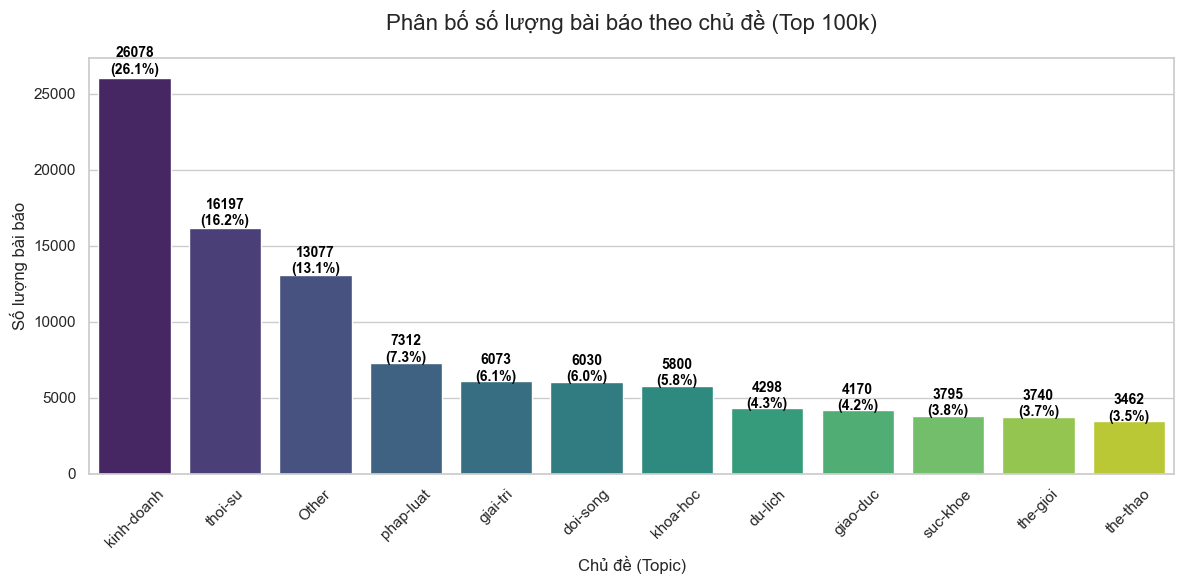


📊 Bảng thống kê chi tiết:
     Topic  count   percent
kinh-doanh  26078 26.069658
   thoi-su  16197 16.191819
     Other  13077 13.072817
 phap-luat   7312  7.309661
  giai-tri   6073  6.071057
  doi-song   6030  6.028071
  khoa-hoc   5800  5.798145
   du-lich   4298  4.296625
  giao-duc   4170  4.168666
  suc-khoe   3795  3.793786
  the-gioi   3740  3.738804
  the-thao   3462  3.460893


In [3]:
import ijson
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ==========================================
# 1. CẤU HÌNH ĐƯỜNG DẪN
# ==========================================
# Đường dẫn tương đối từ Notebook ra file JSON
INPUT_FILE = '../inputs/merged_news_100k_labeled.json' 

# Kiểm tra file có tồn tại không
if not os.path.exists(INPUT_FILE):
    print(f"❌ Không tìm thấy file: {INPUT_FILE}")
    print("👉 Hãy kiểm tra lại đường dẫn tương đối.")
else:
    # print(f"📂 Đang đọc dữ liệu thống kê từ: {INPUT_FILE}")
    
    # ==========================================
    # 2. ĐỌC STREAM & ĐẾM TOPIC
    # ==========================================
    topics = []
    
    try:
        with open(INPUT_FILE, 'rb') as f:
            # Chỉ lấy giá trị của trường "topic" trong từng object
            # Giúp tiết kiệm 99% RAM vì không load nội dung bài báo
            parser = ijson.items(f, 'item.topic')
            
            for topic in parser:
                topics.append(topic)
                
        # print(f"✅ Đã quét xong {len(topics)} bài báo.")
        
        # ==========================================
        # 3. VẼ BIỂU ĐỒ (VISUALIZATION)
        # ==========================================
        # Đếm số lượng
        topic_counts = Counter(topics)
        
        # Chuyển sang DataFrame để vẽ cho đẹp
        df = pd.DataFrame.from_dict(topic_counts, orient='index', columns=['count'])
        df.index.name = 'Topic'
        df.reset_index(inplace=True)
        
        # Sắp xếp giảm dần
        df = df.sort_values(by='count', ascending=False)
        
        # Tính phần trăm
        total = df['count'].sum()
        df['percent'] = (df['count'] / total) * 100

        # Cấu hình biểu đồ
        plt.figure(figsize=(12, 6))
        sns.set_theme(style="whitegrid")
        
        # Vẽ cột
        ax = sns.barplot(x='Topic', y='count', data=df, palette='viridis', hue='Topic', legend=False)
        
        # Thêm nhãn số lượng trên đầu cột
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., height + (height * 0.01),
                        f'{int(height)}\n({df.iloc[i]["percent"]:.1f}%)',
                        ha="center", fontsize=10, color='black', fontweight='bold')

        plt.title('Phân bố số lượng bài báo theo chủ đề (Top 100k)', fontsize=16, pad=20)
        plt.xlabel('Chủ đề (Topic)', fontsize=12)
        plt.ylabel('Số lượng bài báo', fontsize=12)
        plt.xticks(rotation=45) # Xoay nhãn trục X nếu tên dài
        plt.tight_layout()
        
        plt.show()
        
        # In bảng chi tiết ra xem
        print("\n📊 Bảng thống kê chi tiết:")
        print(df[['Topic', 'count', 'percent']].to_string(index=False))

    except Exception as e:
        print(f"❌ Có lỗi xảy ra: {e}")